# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [5]:
print(f"Number of Null email values is: ", df["email"].isnull().sum())

Number of Null email values is:  17


In [6]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [7]:
# Fill email NaNs with "unknown_user"
df["email"].fillna("unknown_user", inplace=True)

/tmp/ipykernel_13/863775349.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["email"].fillna("unknown_user", inplace=True)


In [8]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [9]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_interaction_counts = df.groupby("email")["article_id"].count()
user_interaction_stats = user_interaction_counts.describe()
user_interaction_stats

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

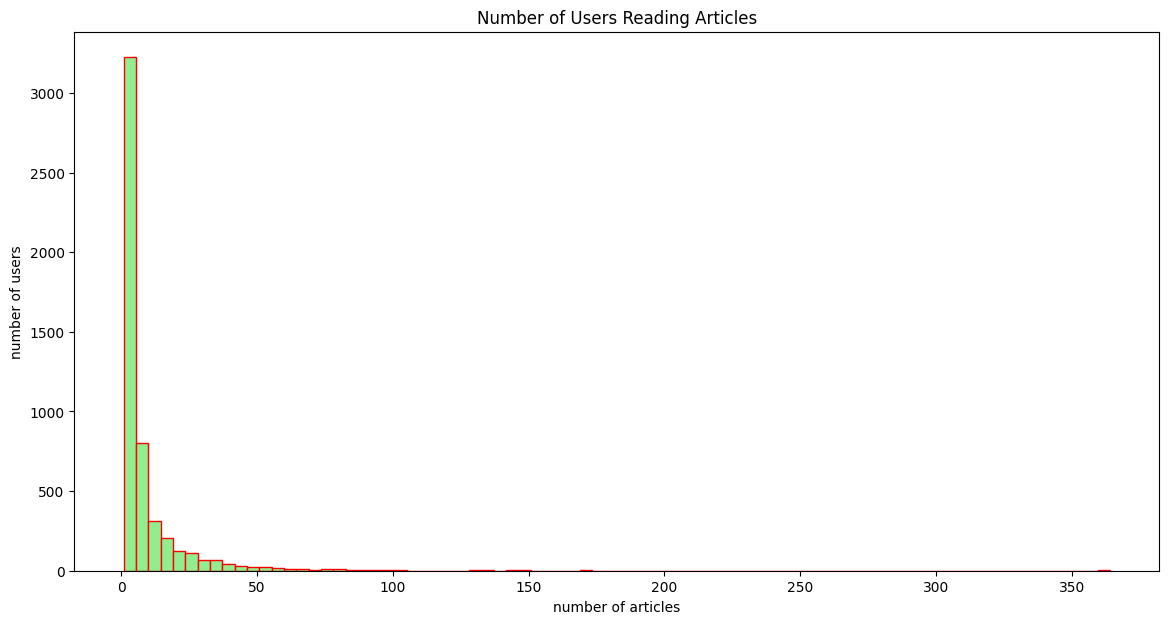

In [13]:
plt.figure(figsize=(14,7))
plt.hist(user_interaction_counts, bins=80, color='lightgreen', edgecolor='red')
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

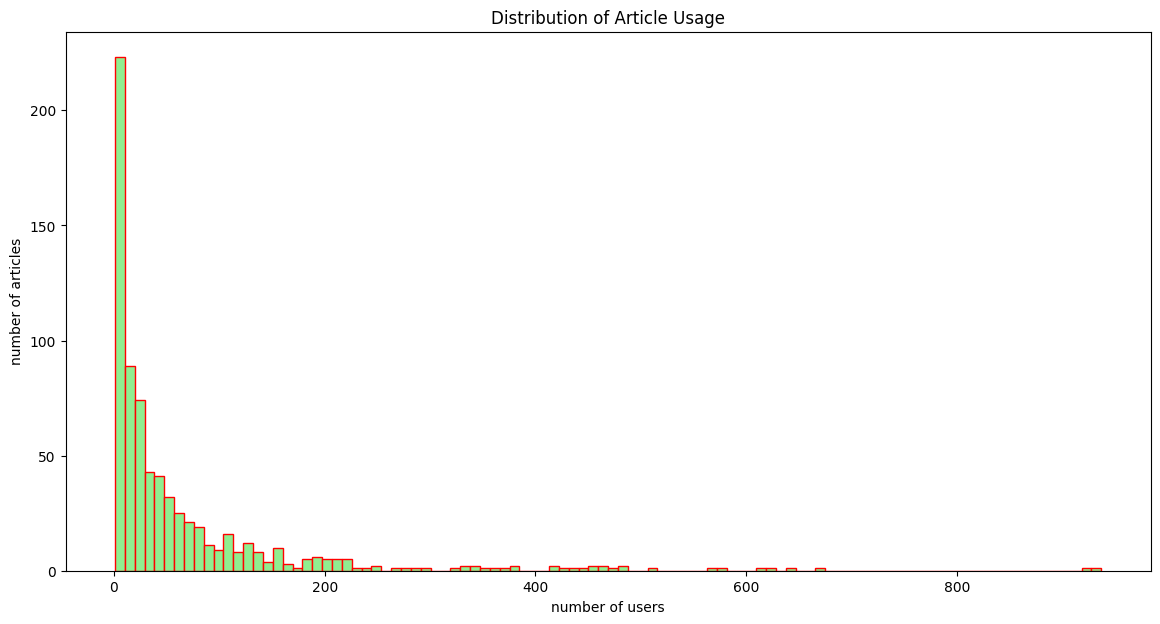

In [14]:
# Create a plot of the number of times each article was read

article_interaction_counts = df.groupby('article_id')['email'].count()
article_interaction_stats = article_interaction_counts.describe() # For a descriptive statistic for the number of times each article was read
# print("Number of times each article was read: ")
# article_interaction_stats
# print("\n\n")

plt.figure(figsize=(14,7))
plt.hist(article_interaction_counts, bins=100, color='lightgreen', edgecolor='red')
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [15]:
# Fill in the median and maximum number of user_article interactions below

median_val = user_interaction_counts.median() # 50% of individuals interact with __3.0__ number of articles or fewer.
max_views_by_user = user_interaction_counts.max() # The maximum number of user-article interactions by any 1 user is _364__.

print(median_val, max_views_by_user)

3.0 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [16]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
most_viewed_article_id = df['article_id'].value_counts().idxmax() # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles = df['title'].value_counts().head(n).index.tolist()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles = df['article_id'].value_counts().head(n).index.tolist()
 
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Fill in the function here
    user_item = df.drop_duplicates(subset=['user_id', 'article_id']).groupby(['user_id', 'article_id']).size().unstack(fill_value=fill_value)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """

    ## This Code has been based on Udacity's Solution Code for the exercise "Collaborative Filtering" 
    ## in the 'Unsupervised Machine Learning and Recommendation Systems' course under the AI/ML Nanodegree program.

    user_idx = user_item.index.get_loc(user_id)
    
    # compute similarity of each user to the provided user
    similarity_matrix = cosine_similarity(user_item, user_item)
    similarity_scores = list(enumerate(similarity_matrix[user_idx]))

    # sort by similarity
    # remove the own user's id
    sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:]
    
    # create list of just the ids
    similar_ids = [i[0] for i in sorted_similarity_scores]
    
    # create list of just the similarities
    similarities = [i[1] for i in sorted_similarity_scores]
    most_similar_users = user_item.index[similar_ids]
    
    if include_similarity:
        return [[a, b] for a, b in zip(most_similar_users, similarities)] # return a list of lists with [[similar_user_id, similarity], ...]
    return most_similar_users # return a list of the users in order from most to least similar

In [28]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Index([3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Index([1, 46, 4201, 253, 824], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Index([4201, 790, 5077], dtype='int64', name='user_id')


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [29]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Your code here

    article_titles = df.drop_duplicates(subset=['article_id']).set_index('article_id')['title']
    article_names = article_titles.loc[article_ids].tolist()
    
    return article_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Your code here
    total_articles = user_item.sum(axis=0)

    subset_counts = total_articles.loc[article_ids]

    sorted_subset_counts = subset_counts.sort_values(ascending=False)

    ranked_article_unique_counts = [[article_id, count] for article_id, count in sorted_subset_counts.items()]
    
    return ranked_article_unique_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Your code here
    users = user_item.loc[user_id]
    article_ids = users[users == 1].index.tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Your code here
    article_ids_seen = set(get_user_articles(user_id)[0])

    similar_users = find_similar_users(user_id)

    recommendations = set()

    for uid in similar_users:
        article_seen_by_similar_users = set(get_user_articles(uid)[0])
        new_recommendation = article_seen_by_similar_users - article_ids_seen
        recommendations.update(new_recommendation)

        if len(recommendations) >= m:
            break

    recs = list(recommendations)[:m]
    
    return recs # return your recommendations for this user_id  

In [30]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['word2vec in data products',
 'this week in data science (april 18, 2017)',
 'data visualization with r: scrum metrics',
 'ml algorithm != learning machine',
 'model bike sharing data with spss',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'this week in data science (may 2, 2017)',
 'use sql with data in hadoop python',
 'challenges in deep learning']

In [31]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [32]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [33]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # Your code here
    # Hint: find similar users, but include their similarity, from there we can find the number of interactions for each neighbor

    similar_users_with_score = find_similar_users(user_id=user_id, include_similarity=True)

    neighbors_df = pd.DataFrame(similar_users_with_score, columns=['neighbor_id', 'similarity'])

    count_interactions = user_item.sum(axis=1).rename('num_interactions')

    neighbors_df = neighbors_df.join(count_interactions, on='neighbor_id')
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False], inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Your code here

    seen_article_ids = set(get_user_articles(user_id)[0])

    top_neighbors = get_top_sorted_users(user_id=user_id)

    recs_list = []

    for neighbor in top_neighbors['neighbor_id']:
        neighbor_article_ids = set(get_user_articles(neighbor)[0])
        new_recs_set = neighbor_article_ids - seen_article_ids

        if new_recs_set:
            ranked_new_recs = get_ranked_article_unique_counts(list(new_recs_set))
            sorted_new_ids = [rec[0] for rec in ranked_new_recs]
            recs_list.extend(sorted_new_ids)

        if len(set(recs_list)) >= m:
            break

    unique_recs = list(dict.fromkeys(recs_list))
    recs = unique_recs[:m]
    
    return recs, get_article_names(recs) # return your recommendations for this user_id

In [34]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 254, 1271, 1328, 1410, 40, 1402]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'customer demographics and sales', 'income (2015): united states demographic measures', 'uci: sms spam collection', 'ensemble learning to improve machine learning results', 'uci: adult - predict income']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
    neighbor_id  similarity  num_interactions
0          5083    0.730297                 5
1          1552    0.577350                 2
2          1890    0.577350                 2
3          1372    0.471405                 3
4          2941    0.433013                 8
37         3586    0.408248                 4
5           331    0.408248                 1
6           348    0.408248                 1
7           378    0.408248                 1
8           496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59

In [36]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user2_6th_sim = get_top_sorted_users(2).iloc[5]['neighbor_id'] # Find the 6th most similar user to user 2
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id'] # Find the 10th most similar user to user 131

In [37]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Since the user is new, it means they have no prior interaction history — no articles read, rated, or interacted with. As a result, functions such as user_user_recs or other collaborative filtering–based methods will fail, because these approaches rely heavily on past user behavior (for example, similarity in reading patterns or preferences among users). This situation is a classic example of the cold-start problem in recommendation systems.

In the cold-start scenario, the system has insufficient data to make personalized recommendations, so it must rely on general patterns or alternative data sources. One straightforward solution is to recommend the most popular articles across all users. This can be easily implemented by using the get_top_articles function, which retrieves the top n most frequently interacted-with articles, or its related function, get_top_article_ids, which provides the corresponding article IDs. This ensures that the new user still receives relevant and high-quality recommendations, even without any personal interaction history.

However, this approach, while simple and effective in the short term, is not personalized. A more refined way to handle the cold-start problem is to use Content-Based Recommendations. Instead of relying solely on user interactions, content-based systems recommend articles based on the similarity between item attributes (e.g., article title, content, tags, or metadata) and the user’s explicitly stated preferences.

To implement this, we can gather basic user profile information at the time of account creation. For example, we could ask the user a few quick questions such as:

“Which domains or topics interest you the most?”

“What is your current role or area of work/study?”

“What type of content do you prefer — technical tutorials, news updates, opinion pieces, etc.?”

Using their responses, we can map these interests to relevant article features and recommend content that aligns with their stated preferences. Over time, as the user starts interacting with the platform — reading, liking, or sharing articles — the system will accumulate behavioral data, allowing it to transition smoothly into a more personalized recommendation strategy, such as collaborative filtering or hybrid models.

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [39]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [40]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [41]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [60]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [61]:
# unique articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates(subset=['article_id'])

In [62]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title']) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)  # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

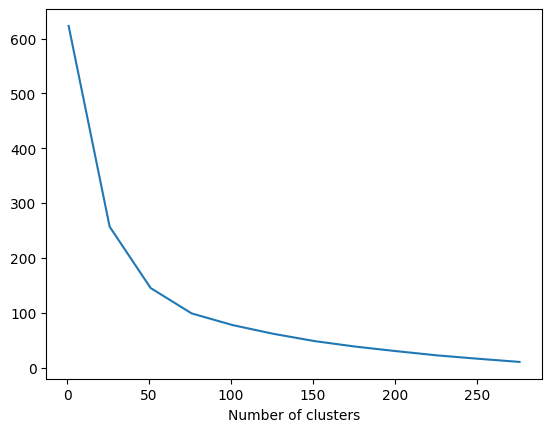

In [46]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [67]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    # Your code here, same as parameters above
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state
).fit(X_lsa)

In [68]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_)) # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map) # apply map to create title clusters

In [49]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 11],
       [ 1, 28],
       [ 2, 23],
       [ 3, 68],
       [ 4, 12],
       [ 5, 29],
       [ 6, 22],
       [ 7, 41],
       [ 8,  4],
       [ 9, 16],
       [10, 20],
       [11, 26],
       [12, 31],
       [13, 19],
       [14, 21],
       [15, 11],
       [16,  6],
       [17, 10],
       [18, 29],
       [19,  8],
       [20, 10],
       [21, 14],
       [22,  7],
       [23, 14],
       [24,  8],
       [25, 11],
       [26,  8],
       [27,  7],
       [28,  8],
       [29, 11],
       [30,  7],
       [31, 11],
       [32,  8],
       [33,  8],
       [34, 13],
       [35, 18],
       [36,  5],
       [37,  7],
       [38,  3],
       [39,  6],
       [40,  5],
       [41, 10],
       [42, 10],
       [43, 11],
       [44,  8],
       [45, 14],
       [46, 12],
       [47,  6],
       [48, 10],
       [49,  9]])

In [51]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
     # Your code here
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].iloc[0]
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    
    # remove the input article_id from the list
    if article_id in articles_in_cluster:
        articles_in_cluster.remove(article_id)
    
    return articles_in_cluster

In [52]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here

    articles_in_cluster = get_similar_articles(article_id)

    ranked_similar_articles = get_ranked_article_unique_counts(articles_in_cluster)

    n_ranked_similar_articles = [article[0] for article in ranked_similar_articles][:n]

    n_ranked_article_names = get_article_names(n_ranked_similar_articles)
    
    return n_ranked_similar_articles, n_ranked_article_names

In [53]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 237, 593, 349, 101, 821, 975, 766, 508, 464]
['data tidying in data science experience', 'deep learning with data science experience', 'upload files to ibm data science experience using the command line', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'how to choose a project to practice data science', 'using rstudio in ibm data science experience', 'the data science process', 'making data science a team sport', 'data science in the cloud', 'use ibm data science experience to detect time series anomalies']


In [54]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

Content-Based Recommendation System

Our Content-Based Recommendation System aims to recommend articles that are similar in content to a given article, based on textual features extracted from the article titles. The system operates through four key stages: Text Vectorization, Dimensionality Reduction, Clustering, and Recommendation Generation.

1. Text Vectorization

The first step involves transforming the raw text data — specifically, the unique article titles — into a numerical representation that can be understood and processed by machine learning algorithms.

For this purpose, we employ the TF-IDF (Term Frequency – Inverse Document Frequency) vectorizer. TF-IDF quantifies the importance of a word within a document relative to the entire corpus.

Term Frequency (TF) measures how frequently a term appears in a document.

Inverse Document Frequency (IDF) reduces the weight of terms that occur very frequently across all documents, as they provide less discriminative value.

The resulting TF-IDF matrix represents each article as a vector of numerical values, where each dimension corresponds to the importance of a particular word. This step essentially converts textual data into a high-dimensional numeric format suitable for mathematical operations.

2. Dimensionality Reduction

Since the TF-IDF matrix can have thousands of dimensions (one for each unique word), it is often very large and sparse. Working directly with such high-dimensional data can be computationally expensive and may lead to overfitting.

To overcome this, we apply Latent Semantic Analysis (LSA) using Truncated Singular Value Decomposition (TruncatedSVD).

LSA helps uncover the latent (hidden) relationships between words and documents by projecting the TF-IDF matrix into a lower-dimensional semantic space.

TruncatedSVD is particularly useful because it performs this dimensionality reduction without requiring the matrix to be dense.

This process not only makes computation faster and more efficient but also helps capture underlying semantic patterns — i.e., it groups words and articles that have similar meanings or contexts, even if they don’t share identical terms.

3. Clustering

Once the dimensionality is reduced, we proceed to cluster the articles based on their semantic similarity. This is the core of our content-based system.

We use the K-Means Clustering algorithm to group articles into a predefined number of clusters. Each cluster represents a collection of articles that share similar textual and semantic characteristics.

To determine the optimal number of clusters, we use the Elbow Method, which involves plotting the within-cluster sum of squares (WCSS) against the number of clusters. After analyzing the curve, we found that 50 clusters provided a good balance between computational efficiency and meaningful grouping.

As a result, each article is assigned to one of these 50 clusters, where similar articles are grouped together.

4. Generating Recommendations

When a recommendation is requested (for instance, when a user reads or interacts with an article), the system performs the following steps:

Cluster Identification: It identifies which of the 50 clusters the given article belongs to.

Cluster Retrieval: It retrieves all other articles within the same cluster, assuming they share similar content.

Ranking by Popularity: To further refine recommendations, we sort the retrieved articles based on their popularity metrics — such as total interactions, reads, or ratings.

Final Recommendation: Finally, the system recommends the top n articles from this ranked list as the most relevant suggestions.

This approach ensures that recommendations are contextually similar to what the user has already viewed, while also prioritizing content that is generally well-received by the broader audience.

**Possible Improvements:

While the current approach provides a strong baseline, there are several ways to enhance its accuracy and contextual understanding:

Use of Advanced NLP Models:

TF-IDF is a frequency-based technique that doesn’t capture the true semantics or context of words.

We can replace or augment it with advanced NLP-based embeddings such as Word2Vec, GloVe, or BERT embeddings, which understand word relationships in context.

For example, BERT (Bidirectional Encoder Representations from Transformers) can capture deeper semantic meanings, allowing the model to identify articles with similar topics even if they use very different vocabulary.

Utilizing Additional Textual Data:

Currently, we only use article titles for feature extraction, which may not provide enough context.

Incorporating additional data such as:

1.Full article body/content
2.Article summaries
3.Keywords or tags can significantly enhance the richness of the text representation and improve the quality of clustering and recommendations.

Hybrid Recommendation Approach:

Over time, as user interaction data accumulates, we can combine content-based and collaborative filtering methods to form a hybrid recommendation system, achieving better personalization.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [55]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [58]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

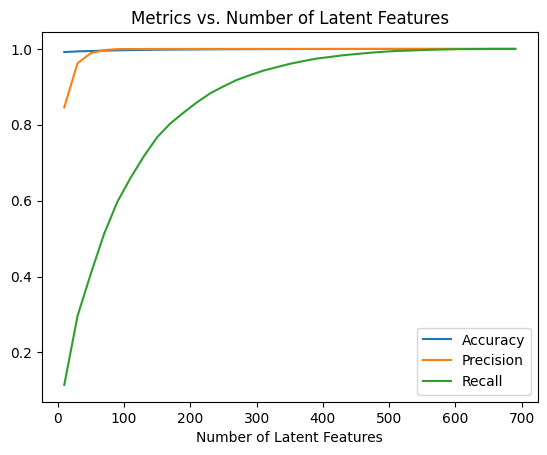

In [59]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

While increasing the number of latent features can improve the model’s ability to predict the 1’s and 0’s in the user-item interaction matrix, it doesn’t necessarily translate to better recommendation quality. A higher number of features typically allows the model to capture more variance and complex patterns in the data, but beyond a certain point, it starts to overfit — meaning it memorizes the training data instead of generalizing well to unseen users or items. Additionally, using too many features increases computational cost and memory usage, which can make the model inefficient and slow, especially when dealing with large datasets.

Based on the plot provided, there appears to be a point of diminishing returns around 150 to 300 latent features. Within this range, the model captures most of the meaningful variance in the data without a significant increase in complexity or risk of overfitting. Therefore, selecting a value in this range strikes a good balance between model performance, generalization ability, and computational efficiency.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [69]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    all_article_idx = list(user_item.columns)
    article_idx = all_article_idx.index(article_id)
    
    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix 
    cos_sim = cosine_similarity(vt.T, vt.T)
    
    # Get similarities only for the cos_sim of the article_idx
    similarity_scores = list(enumerate(cos_sim[article_idx]))
    
    # Sort and return the articles, don't include the own article
    sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    most_similar_idx = [score[0] for score in sorted_similarity_scores[1:]]
    similarities = [score[1] for score in sorted_similarity_scores[1:]]

    most_similar_items = [all_article_idx[idx] for idx in most_similar_idx]
    
    if include_similarity:
        return list(zip(most_similar_items, similarities)) # return a list of lists with [[similar_article_id, similarity], ...]
    
    return most_similar_items

In [70]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [71]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [72]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [73]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['country statistics: crude oil - exports',
 'airbnb data for analytics: athens reviews',
 'use spark r to load and analyze data',
 'country statistics: crude oil - proved reserves',
 'top analytics tools in 2016',
 'airbnb data for analytics: paris calendar',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 'advancements in the spark community',
 'collecting data science cheat sheets']

In [74]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

The recommendations generated by the Matrix Factorization model for article 4 appear to be qualitatively rich and semantically meaningful. For instance, the system recommends articles such as “Airbnb data for analytics: Athens reviews” and “Top analytics tools in 2016.” These recommendations demonstrate that the model has learned deeper, latent relationships between articles — beyond just matching surface-level keywords.

Unlike a simple Content-Based approach, which might have only suggested articles containing similar words like “spark” or “restaurant,” the Singular Value Decomposition (SVD) model identifies underlying patterns in how users interact with articles. This allows it to infer that users interested in certain topics (e.g., data analytics or data processing) may also find related, but not necessarily keyword-similar, articles relevant. This capability illustrates the strength of Matrix Factorization techniques in uncovering hidden user preferences and producing more nuanced, personalized recommendations.

**Evaluating the Effectiveness of Recommendations**

To determine if the recommendations generated by the Matrix Factorization model are an improvement over existing methods (such as those in Sections 2, 3, or 4), we can conduct several forms of evaluation:

**1.Offline Evaluation (Quantitative Testing):

Use metrics such as Precision@K, Recall@K, and Mean Average Precision (MAP) to measure how well the recommendations match actual user interactions.

Perform cross-validation to ensure that the model generalizes well to unseen data.

Compare these metrics with the results from Rank-Based, Content-Based, and User-User Collaborative Filtering systems.

**2.Online Evaluation (User Testing / A/B Testing):

Deploy the Matrix Factorization–based recommender to a subset of users.

Compare key engagement metrics — such as click-through rate (CTR), time spent reading, and return visits — against the baseline system.

Collect qualitative feedback from users to assess perceived relevance and satisfaction.

**3.Hybrid Evaluation (Qualitative Analysis):

Examine individual recommendation lists to ensure the system provides diverse yet relevant content.

Assess whether the model avoids recommending overly similar or redundant items.


**A Hybrid Strategy

To achieve a balance between personalization and scalability, we can employ a hybrid recommendation strategy that leverages different methods depending on the user’s engagement level:

New Users (No Interaction History):

Since personalization isn’t possible yet, start with a Rank-Based recommendation approach that highlights the most popular or trending articles across the platform.

This ensures immediate value for new users and helps introduce them to high-quality, widely liked content.

Recently Active Users (Limited History):

Once a user has interacted with a few articles (e.g., 5–10), transition to a Content-Based system.

This approach uses the content of the articles they’ve read to recommend similar ones, providing early-stage personalization based on interests.

Established Users (Rich Interaction History):

For users with substantial interaction data, deploy the Matrix Factorization model.

This model can infer deeper patterns in their reading behavior, allowing for highly personalized recommendations that go beyond simple keyword or popularity matching.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [75]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/__main__.py", line 5, in <module>
    main()
  File "/opt/venv/lib/python3.10/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 582, in convert_notebooks
    raise ValueError(msg)
ValueError: Please specify an output format with '--to <format>'.
The following formats are available: ['a

1